In [ ]:
!pip install gensim pyLDAvis

In [ ]:
import sys
import re, numpy as np
from pprint import pprint

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings, logging

from collections import Counter

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Topic Modeling

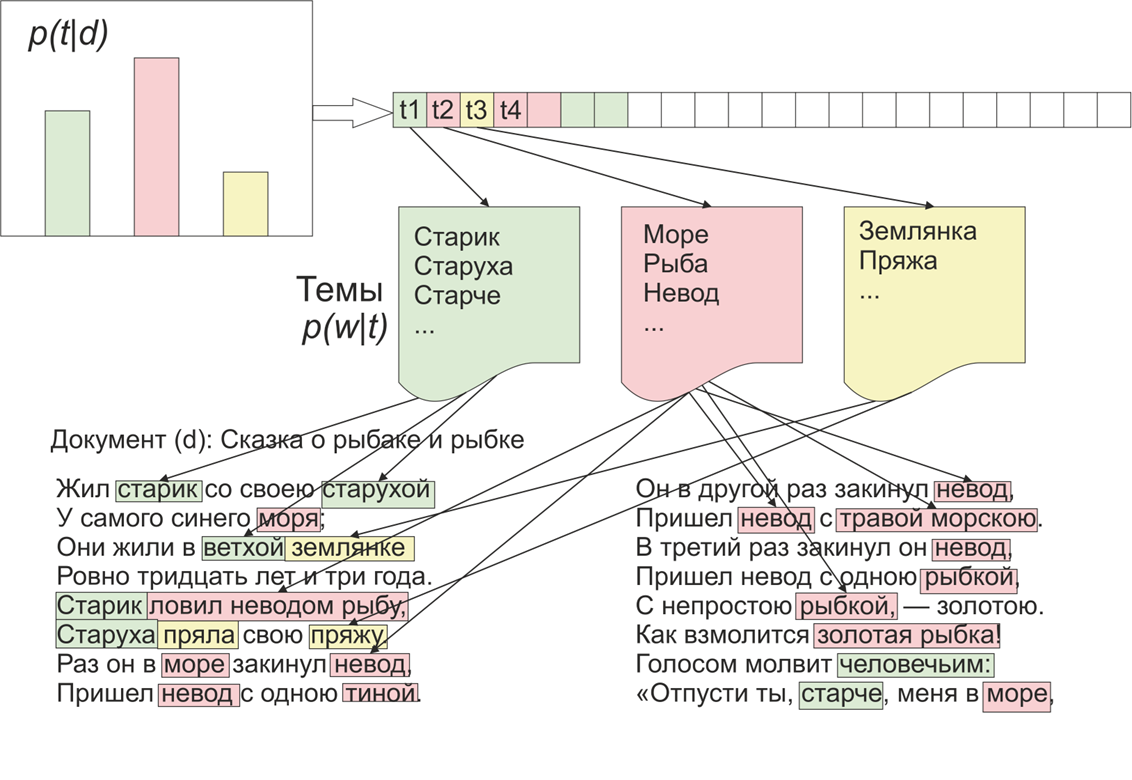

### Создадим список стоп-слов

In [ ]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

### Загрузим nltk датасет

В качестве данных возьмем Lewis Carroll's "Alice in Wonderland"

In [ ]:
alice = nltk.corpus.gutenberg.sents('carroll-alice.txt')

### Предобработка

In [ ]:
wnl = WordNetLemmatizer()

def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts] # lowercase, tokenize
    texts_out = []
    for sent in texts:
        texts_out.append([wnl.lemmatize(token) for token in sent])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(alice)  # processed Text Data!

Build the bigram and trigram models

[Phrases - collocation detection](https://radimrehurek.com/gensim/models/phrases.html)


In [ ]:
bigram = gensim.models.Phrases(data_ready, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_ready], threshold=100)  # Phraser == FrozenPhrases
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def get_ngrams(texts_out):
    texts_out = [bigram_mod[doc] for doc in texts_out]
    texts_out = [trigram_mod[bigram_mod[doc]] for doc in texts_out]
    return texts_out

In [ ]:
data_ready = get_ngrams(data_ready)

In [ ]:
for item in data_ready:
  for token in item:
    if len(item) < 4 and '_' in token:
      print(item)

['oh', 'beg_pardon']
['beg_pardon']
['said', 'march_hare']
['said', 'march_hare']
['mean', 'march_hare', 'went']
['said', 'march_hare']
['said', 'march_hare']
['said', 'march_hare']
['mock_turtle', 'story']
['mock_turtle']
['said', 'mock_turtle']
['mock_turtle', 'went']
['said', 'mock_turtle']
['said', 'mock_turtle', 'sigh']
['course', 'said', 'mock_turtle']
['cried', 'mock_turtle']
['mock_turtle', 'went', 'throw']
['said', 'mock_turtle']
['said', 'mock_turtle', 'gryphon']
['waiting', 'shingle', 'join_dance']
['join_dance']
['join_dance']
['join_dance']
['join_dance']
['join_dance']
['join_dance']
['explain', 'said', 'mock_turtle']
['mock_turtle', 'repeated', 'thoughtfully']
['mock_turtle', 'persisted']
['soup', 'evening', 'beautiful_soup']
['soup', 'evening', 'beautiful_soup']
['beau', 'ootiful', 'soo_oop']
['beau', 'ootiful', 'soo_oop']
['beautiful_soup']
['pennyworth', 'beautiful_soup']
['beau', 'ootiful', 'soo_oop']
['beau', 'ootiful', 'soo_oop']
['fifteenth', 'said', 'march_hare']

### Создание словаря

In [ ]:
id2word = corpora.Dictionary(data_ready)

In [ ]:
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

###LDA

[оригинальная работа](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)

[Gensim LDA](https://radimrehurek.com/gensim/models/ldamodel.html)

In [ ]:
%%time

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=4,
    random_state=2023,
    update_every=1, # Number of documents to be iterated through for each update
    chunksize=10, # == batch size
    passes=100, # Number of passes through the corpus during training
    alpha='symmetric', # A-priori belief on document-topic distribution
    iterations=150, # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
    per_word_topics=True,
)

pprint(lda_model.print_topics())

[(0,
  '0.053*"king" + 0.031*"voice" + 0.023*"white_rabbit" + 0.023*"one" + '
  '0.016*"hatter" + 0.016*"sob" + 0.016*"teacup" + 0.015*"shrill" + '
  '0.013*"first" + 0.012*"knee"'),
 (1,
  '0.038*"queen" + 0.035*"little" + 0.025*"mock_turtle" + 0.023*"eye" + '
  '0.014*"sister" + 0.013*"day" + 0.012*"alice" + 0.012*"gave" + '
  '0.012*"nothing" + 0.011*"place"'),
 (2,
  '0.022*"time" + 0.022*"slate" + 0.021*"simple" + 0.021*"never" + 0.015*"way" '
  '+ 0.015*"hand" + 0.015*"grown" + 0.015*"jury" + 0.014*"went" + '
  '0.014*"alice"'),
 (3,
  '0.140*"said" + 0.042*"alice" + 0.026*"change" + 0.022*"long" + 0.018*"knew" '
  '+ 0.018*"head" + 0.017*"child" + 0.016*"must" + 0.014*"began" + '
  '0.013*"half"')]
CPU times: user 1min 2s, sys: 254 ms, total: 1min 2s
Wall time: 1min 16s


### Распределение word counts по документам

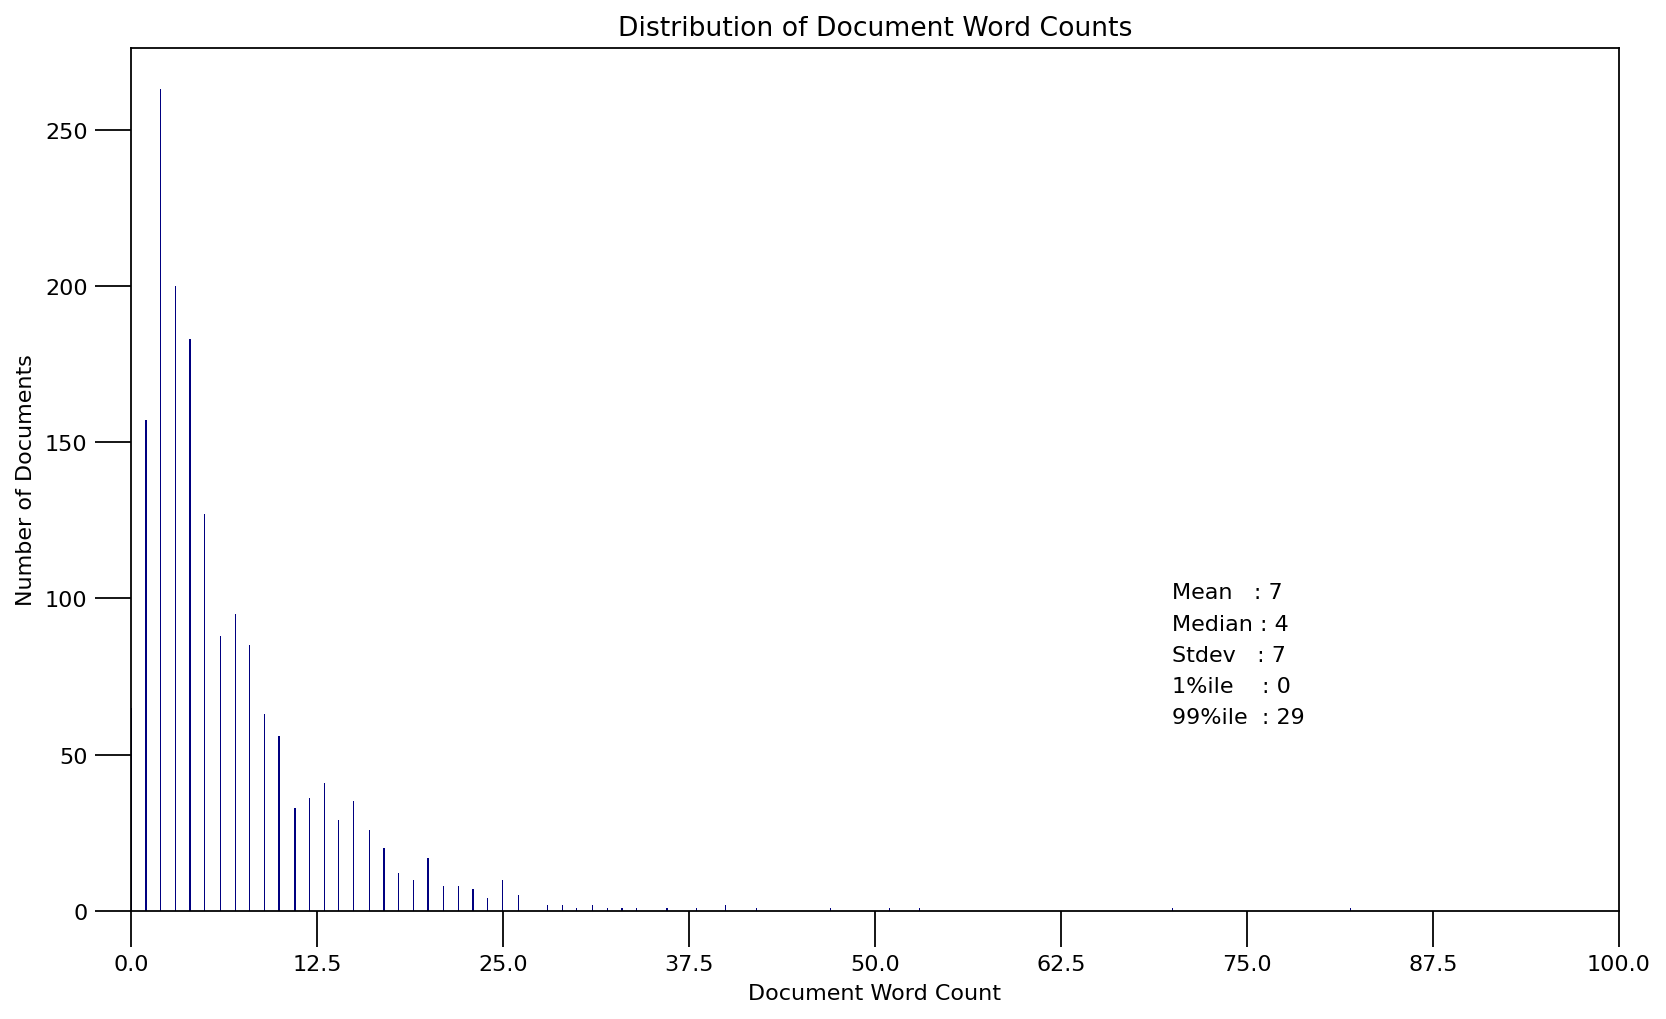

In [ ]:
doc_lens = [len(d) for d in data_ready]

plt.figure(figsize=(12, 7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(70, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(70,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(70,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(70,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(70,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 100, 9))
plt.title('Distribution of Document Word Counts')
plt.show()

In [ ]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

### Визуализация word count и word weights

<ipython-input-47-b7d800eaacf0>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')


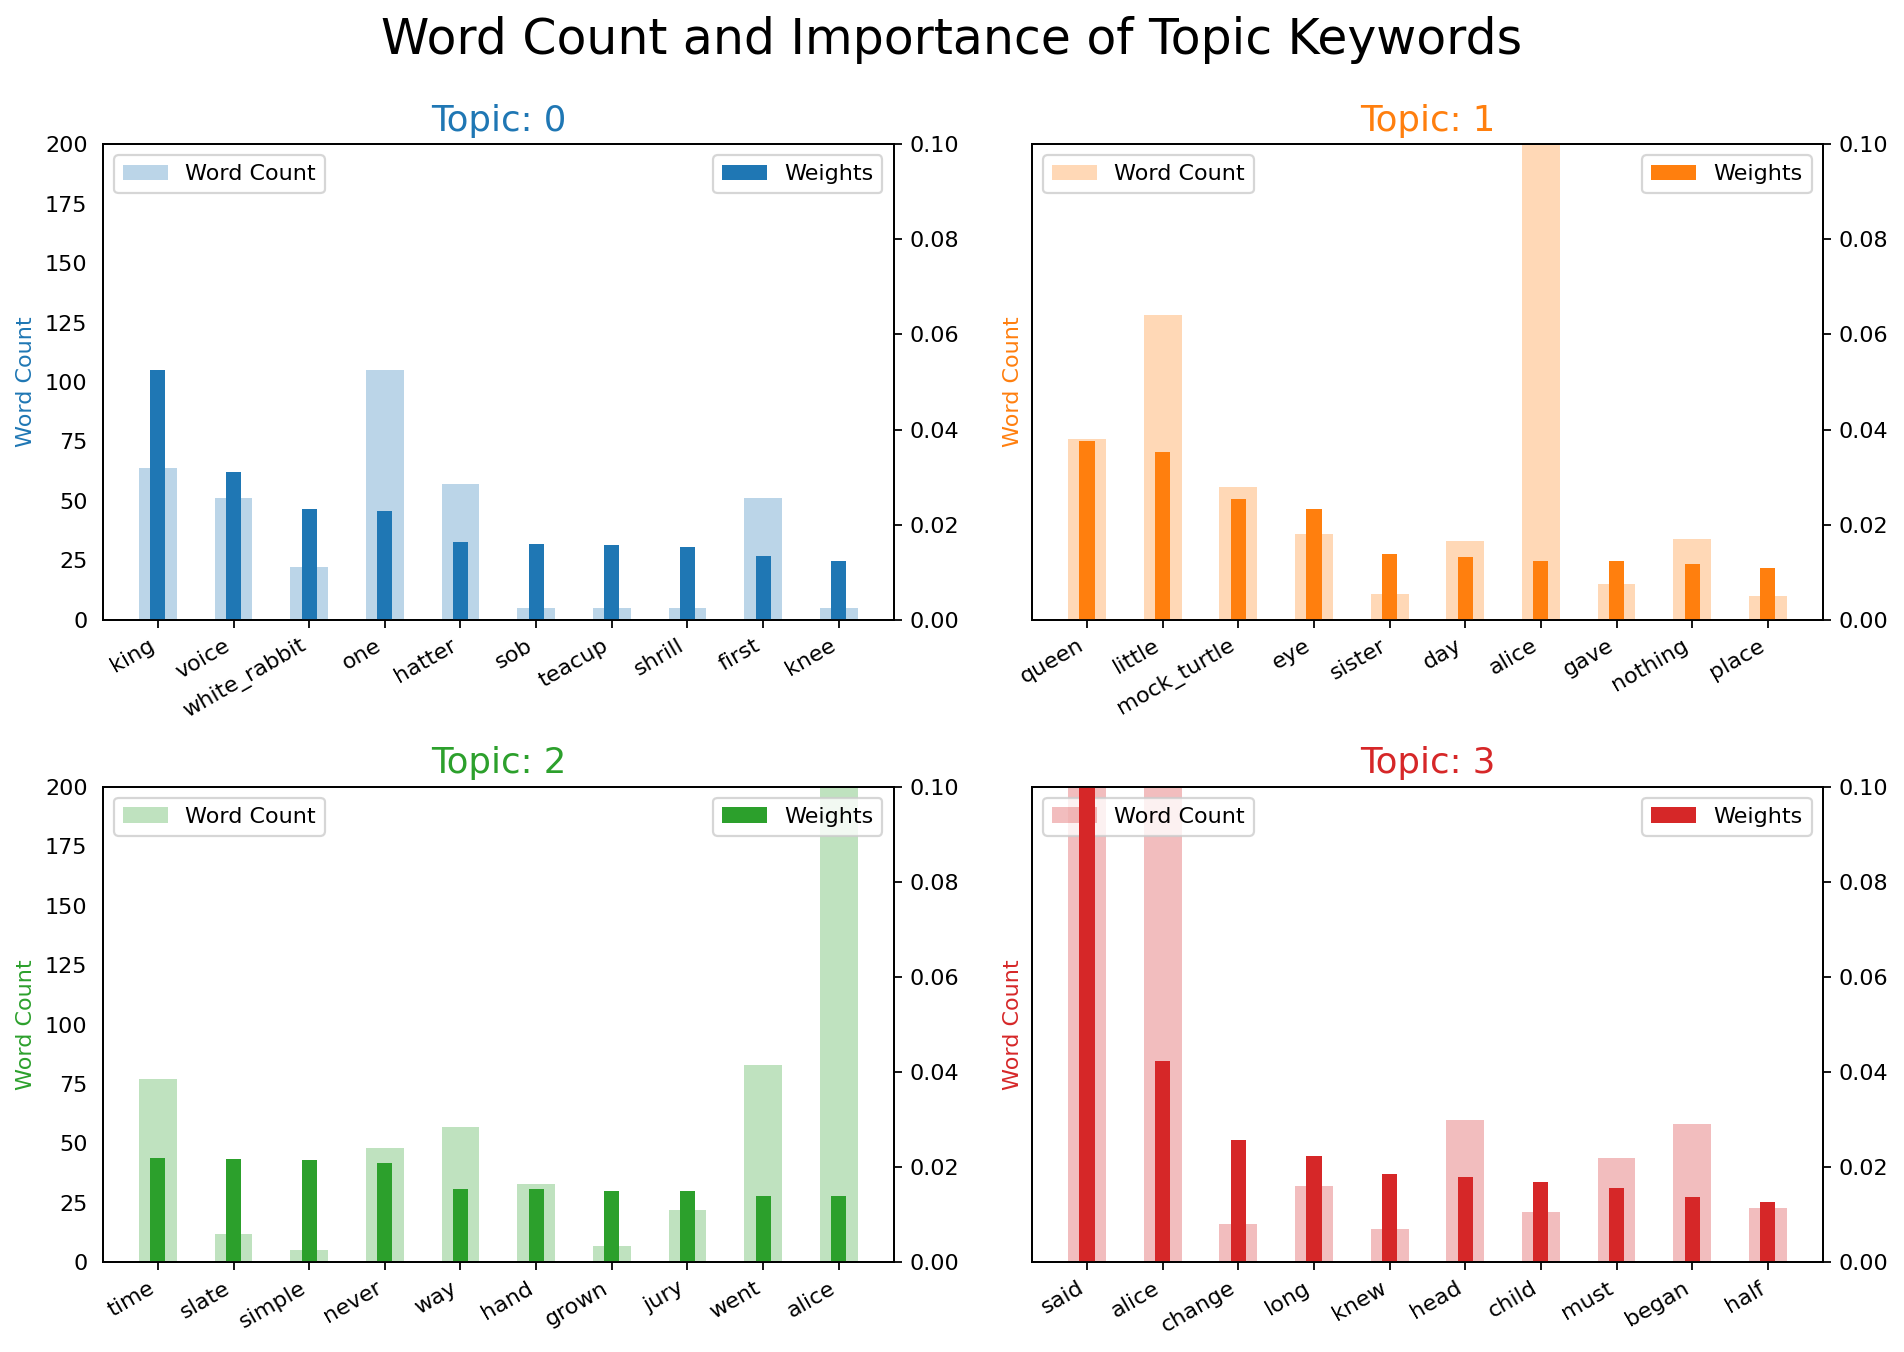

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 200)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

### Раскраска предложений

In [ ]:
def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1 + start) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-1),
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

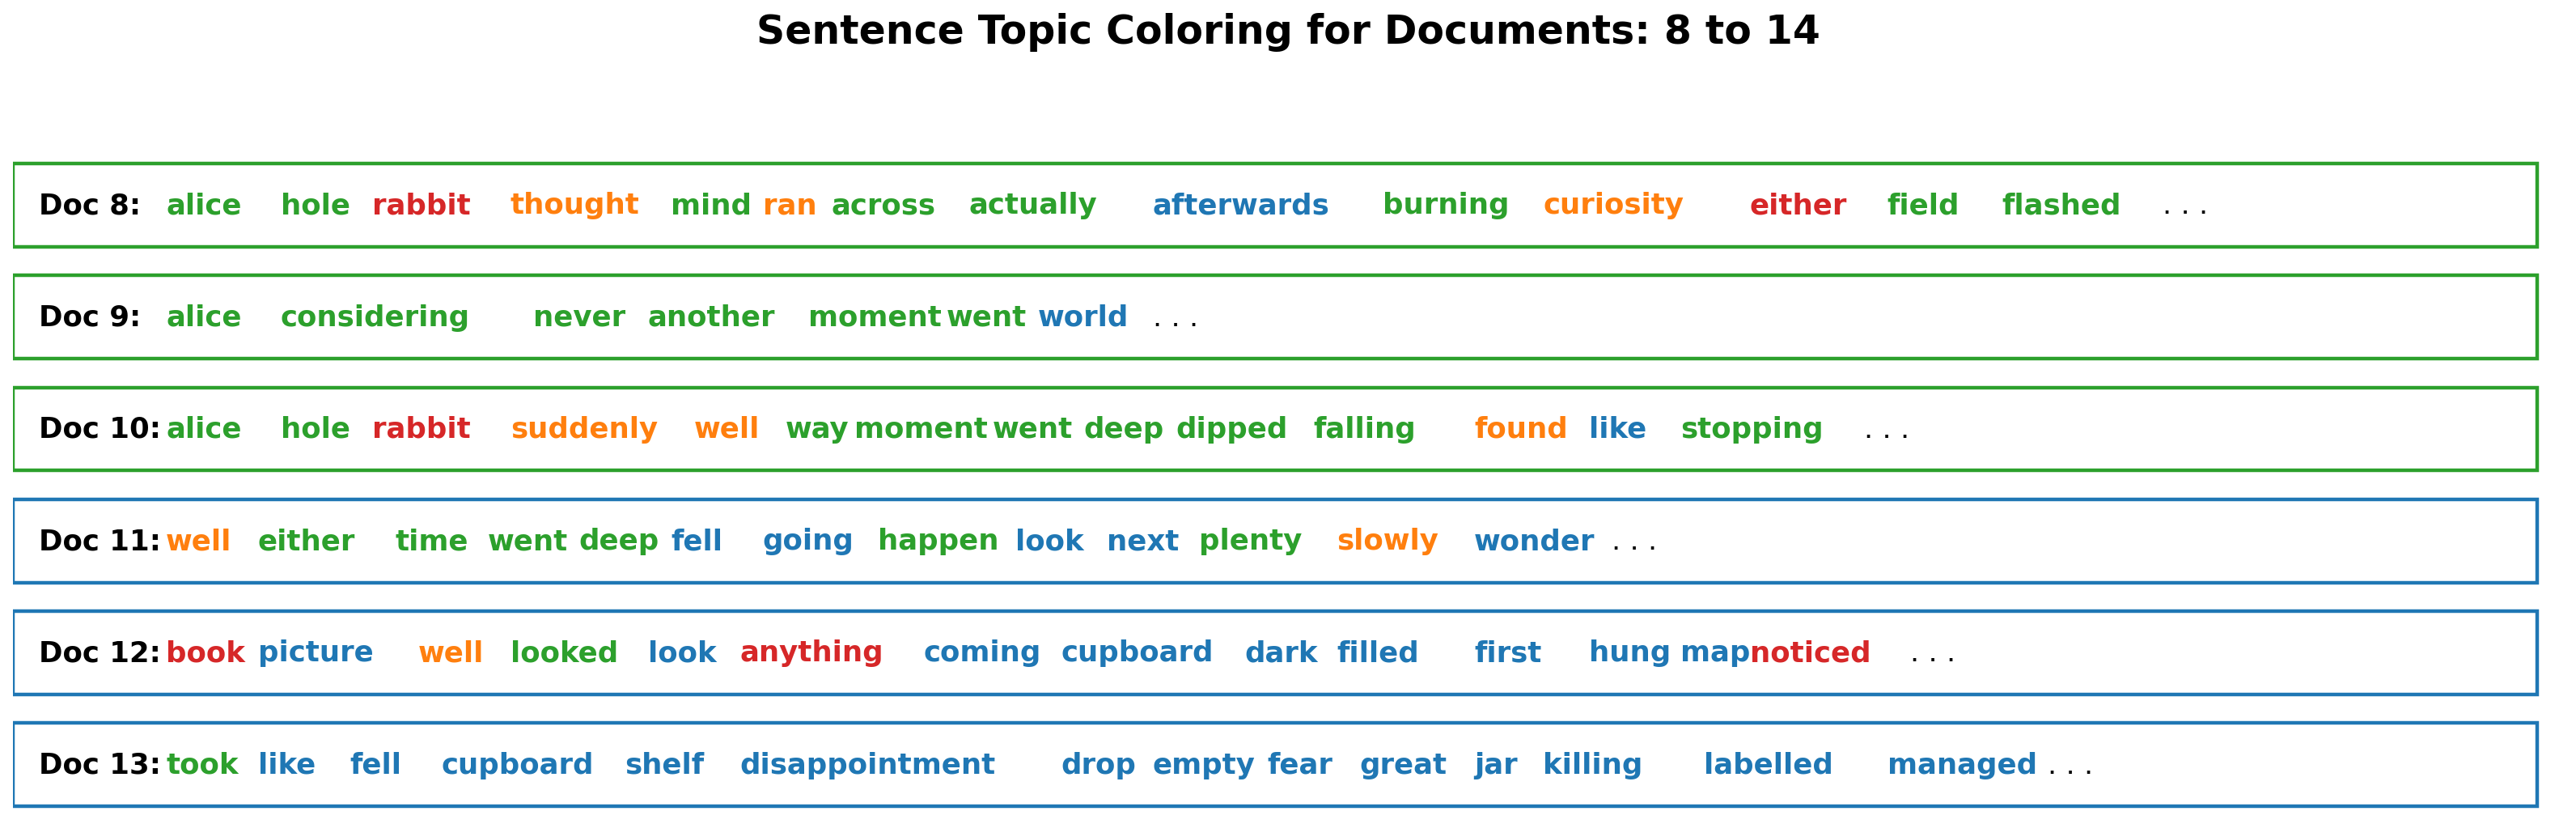

In [ ]:
sentences_chart(start=8, end=15)

### pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.211370  0.145228       1        1  26.856643
0      0.220337  0.133924       2        1  25.028478
2      0.010218 -0.141724       3        1  24.755661
1     -0.019185 -0.137427       4        1  23.359218, topic_info=             Term        Freq       Total Category  logprob  loglift
147          said  421.000000  421.000000  Default  30.0000  30.0000
1679         king  148.000000  148.000000  Default  29.0000  29.0000
1354        queen   98.000000   98.000000  Default  28.0000  28.0000
205        little   92.000000   92.000000  Default  27.0000  27.0000
534         voice   87.000000   87.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1707  unfortunate   18.934202   26.410581   Topic4  -4.9282   1.1214
1           alice   32.199920  198.005833   Topic4  -4.3972  -0.3622
576       strange   18.341169   34.525988   Topic4  -4.9600   0.8216
235         dream   19.302267   54.517429   Topic4  -4.9089   0.4159
1844      gryphon   19.667507   83.195427   Topic4  -4.8902   0.0120

[193 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
892       3  0.992232    added
196       2  0.994338      air
1         1  0.641395    alice
1         3  0.191914    alice
1         4  0.161611    alice
...     ...       ...      ...
2044      2  0.905093  witness
2044      3  0.041141  witness
176       1  0.975716     word
1550      3  0.934764  writing
688       3  0.993812      yet

[249 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])